In [35]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [66]:
# boilerplate code to save model to Google Drive later
from google.colab import drive
drive.mount('/content/drive')

save_path = "/content/drive/MyDrive/finetuned_wav2vec2_emotion_model"

Mounted at /content/drive


### Installations and Imports

In [37]:
! pip install kagglehub
! pip install torchaudio transformers librosa
! pip install datasets

In [38]:
import kagglehub
import librosa
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForSequenceClassification
import torch
import pandas as pd
from datasets import Dataset
from transformers import Wav2Vec2Processor, Trainer, TrainingArguments, Wav2Vec2Config
from transformers import DataCollatorWithPadding
from sklearn.metrics import accuracy_score

In [39]:
# download RAVDESS dataset
path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")
print("Dataset downloaded to:", path)

# find all .wav files
all_files = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith(".wav"):
            all_files.append(os.path.join(root, file))

print(f"Found {len(all_files)} audio files.")

Dataset downloaded to: /kaggle/input/ravdess-emotional-speech-audio
Found 2880 audio files.


### Data Preparation

In [40]:
# loop through all files and get emotion from label
data = []
code_to_emotion = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}


def get_true_label_from_filename(filename):
    emotion_code = filename.split("-")[2]  # 3rd field (0-indexed)
    return code_to_emotion.get(emotion_code, "unknown")

for file in all_files:
    fname = os.path.basename(file)
    true = get_true_label_from_filename(fname)
    data.append({"file_path": file, "labeled_emotion": true})

df = pd.DataFrame(data)
print(df.head(100))

                                            file_path labeled_emotion
0   /kaggle/input/ravdess-emotional-speech-audio/A...       surprised
1   /kaggle/input/ravdess-emotional-speech-audio/A...         neutral
2   /kaggle/input/ravdess-emotional-speech-audio/A...         disgust
3   /kaggle/input/ravdess-emotional-speech-audio/A...         disgust
4   /kaggle/input/ravdess-emotional-speech-audio/A...         neutral
..                                                ...             ...
95  /kaggle/input/ravdess-emotional-speech-audio/A...         fearful
96  /kaggle/input/ravdess-emotional-speech-audio/A...            calm
97  /kaggle/input/ravdess-emotional-speech-audio/A...           angry
98  /kaggle/input/ravdess-emotional-speech-audio/A...         fearful
99  /kaggle/input/ravdess-emotional-speech-audio/A...       surprised

[100 rows x 2 columns]


In [41]:
# create mappings from the list of emotions
label_list = df['labeled_emotion'].unique().tolist()

# create mappings for label2id and id2label
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for i, label in enumerate(label_list)}

print("label2id:", label2id)
print("id2label:", id2label)

label2id: {'surprised': 0, 'neutral': 1, 'disgust': 2, 'fearful': 3, 'sad': 4, 'calm': 5, 'happy': 6, 'angry': 7}
id2label: {0: 'surprised', 1: 'neutral', 2: 'disgust', 3: 'fearful', 4: 'sad', 5: 'calm', 6: 'happy', 7: 'angry'}


In [42]:
def preprocess_function(batch):
    # load the audio from file
    file_path = batch["file_path"]
    speech_array, sampling_rate = librosa.load(file_path, sr=8000)  # load at 8kHz

    # extract features using the feature extractor (without using the processor)
    inputs = feature_extractor(
        speech_array,
        sampling_rate=sampling_rate,
        padding=True,
        return_tensors="pt"
    )

    # return the input values and the label
    return {
        "input_values": inputs.input_values[0],  # the extracted input values
        "labels": label2id[batch["labeled_emotion"]]  # Label ID
    }

### Model Setup

In [43]:
model_name = "facebook/wav2vec2-base"

# load feature extractor and model
model = Wav2Vec2ForSequenceClassification.from_pretrained(model_name)
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name, sampling_rate=8000)

# freeze the feature extractor
model.freeze_feature_extractor()

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:2306: FutureWarning: The method `freeze_feature_extractor` is deprecated and will be removed in Transformers v5. Please use the equivalent `freeze_feature_encoder` method instead.
  warni

In [44]:
# create test/train split

df['emotion'] = df['labeled_emotion'].map(label2id)
dataset = Dataset.from_pandas(df)

split_dataset = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split_dataset['train']
test_dataset = split_dataset['test']

# apply the preprocessing function to the dataset
train_dataset = train_dataset.map(preprocess_function, remove_columns=["file_path", "labeled_emotion"])
test_dataset = test_dataset.map(preprocess_function, remove_columns=["file_path", "labeled_emotion"])


Map:   0%|          | 0/2304 [00:00<?, ? examples/s]

Map:   0%|          | 0/576 [00:00<?, ? examples/s]

In [45]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Train dataset size: 2304
Test dataset size: 576


In [46]:
'''
Dropout: You may want to adjust the dropout values based on your task and experiment with different configurations.
Freezing: If you have frozen the feature extractor (as you did earlier), it may not be necessary to adjust dropout, but if you are fine-tuning the whole model, keep dropout to avoid overfitting.
'''

config = Wav2Vec2Config.from_pretrained(
    model_name,
    num_labels=len(label_list),
    label2id=label2id,
    id2label=id2label,
    hidden_dropout=0.3,       # dropout in transformer layers
    attention_dropout=0.3,    # dropout in attention
)

model = Wav2Vec2ForSequenceClassification.from_pretrained(
    model_name,
    config=config
)

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
training_args = TrainingArguments(
    output_dir="./wav2vec2_finetuned_emotion_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=30,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)


In [49]:
def compute_metrics(p):
    predictions, labels = p
    # convert logits to predicted class indices (to get predicted label for each sample)
    preds = predictions.argmax(axis=1)

    accuracy = accuracy_score(labels, preds)
    return {"accuracy": accuracy}

In [50]:
# initialize the trainer
data_collator = DataCollatorWithPadding(feature_extractor)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [51]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.903300,1.772935,0.373264
2,1.691300,1.456162,0.477431
3,1.347700,1.195671,0.541667
4,1.064700,1.391119,0.519097
5,0.859500,1.144782,0.621528
6,0.723000,0.973065,0.682292
7,0.648100,0.624591,0.810764
8,0.519500,0.491099,0.850694
9,0.456700,0.672948,0.815972
10,0.421300,0.386085,0.895833


TrainOutput(global_step=8640, training_loss=0.4257215664756519, metrics={'train_runtime': 1957.4776, 'train_samples_per_second': 35.311, 'train_steps_per_second': 4.414, 'total_flos': 1.329047074006973e+18, 'train_loss': 0.4257215664756519, 'epoch': 30.0})

In [67]:
# after training is complete, save the model and feature extractor
model.save_pretrained(save_path)
feature_extractor.save_pretrained(save_path)

['/content/drive/MyDrive/finetuned_wav2vec2_emotion_model/preprocessor_config.json']

In [53]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.10147135704755783, 'eval_accuracy': 0.9878472222222222, 'eval_runtime': 9.3426, 'eval_samples_per_second': 61.653, 'eval_steps_per_second': 7.707, 'epoch': 30.0}


# Visuals

In [64]:
import matplotlib.pyplot as plt

# examine trainer log history
log_df = pd.DataFrame(trainer.state.log_history)
display(log_df.head())

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,2.0800,1.302130,0.000003,0.173611,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0684,1.285656,0.000006,0.347222,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0515,2.152947,0.000009,0.520833,150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0002,2.781134,0.000012,0.694444,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.9033,4.559565,0.000015,0.868056,250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


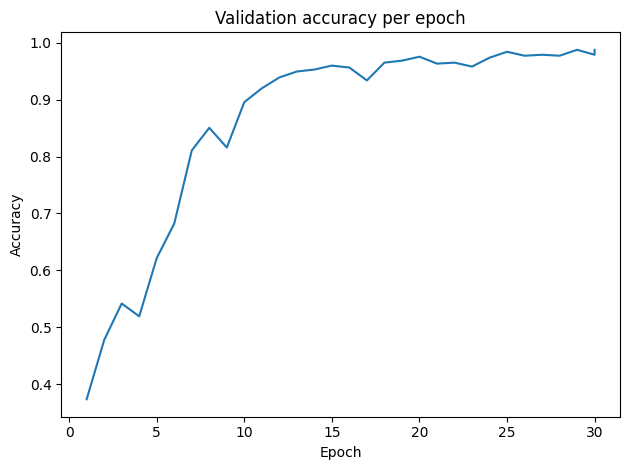

In [65]:
# visualize
acc_df = log_df[['epoch', 'eval_accuracy']].dropna()

plt.figure()
plt.plot(acc_df['epoch'], acc_df['eval_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation accuracy per epoch')
plt.tight_layout()
plt.savefig('val_accuracy.png', dpi=300)
plt.show()

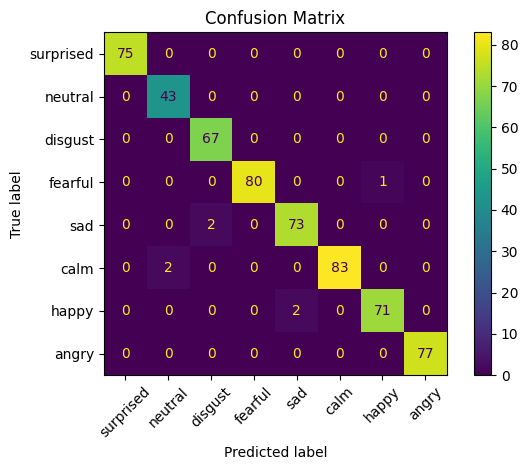

              precision    recall  f1-score   support

   surprised       1.00      1.00      1.00        75
     neutral       0.96      1.00      0.98        43
     disgust       0.97      1.00      0.99        67
     fearful       1.00      0.99      0.99        81
         sad       0.97      0.97      0.97        75
        calm       1.00      0.98      0.99        85
       happy       0.99      0.97      0.98        73
       angry       1.00      1.00      1.00        77

    accuracy                           0.99       576
   macro avg       0.99      0.99      0.99       576
weighted avg       0.99      0.99      0.99       576



In [68]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

# get fresh predictions on the test split
pred_output = trainer.predict(test_dataset)
y_true = pred_output.label_ids
y_pred = pred_output.predictions.argmax(axis=1)

# generate confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    display_labels=label_list,
    xticks_rotation=45
)
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

# text report (precision/recall/F1)
print(classification_report(y_true, y_pred, target_names=label_list))

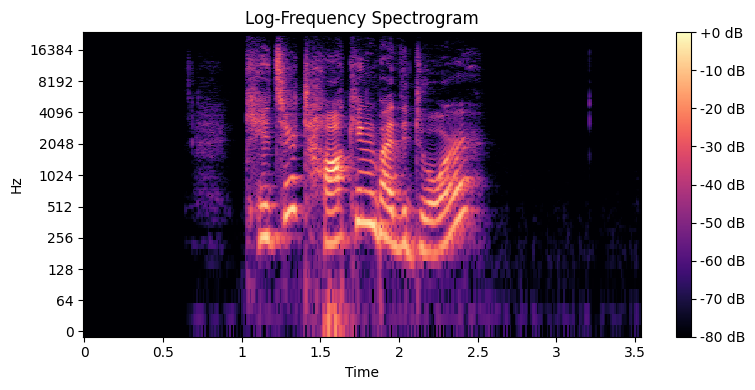

In [56]:
import numpy as np
import librosa.display

audio_path = df['file_path'].iloc[0]

# load audio
y, sr = librosa.load(audio_path, sr=None)

# compute the STFT magnitude
D = np.abs(librosa.stft(y))

# convert to decibels
S_db = librosa.amplitude_to_db(D, ref=np.max)

# plot
plt.figure(figsize=(8, 4))
librosa.display.specshow(
    S_db,
    sr=sr,
    x_axis='time',
    y_axis='log'
)
plt.colorbar(format='%+2.0f dB')
plt.title('Log-Frequency Spectrogram')
plt.tight_layout()
plt.show()